# Exploring Shastry-Sutherland model with symmetric RBM (similar machine as in Science 2017)

In [252]:
import netket as nk
import numpy as np
import time
import json
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import jax
import flax
import pprint
print("NetKet version: {}".format(nk.__version__))
print("NumPy version: {}".format(np.__version__))

NetKet version: 3.1.2
NumPy version: 1.20.3


Setup relevant parameters

In [253]:
"""lattice"""
SITES    = 16            # 4, 8, 16, 20 ... number of vertices in a tile determines the tile shape 
JEXCH1   = .3            # nn interaction
JEXCH2   = 1            # nnn interaction
#USE_MSR  = True        # should we use a Marshall sign rule?
"""machine learning"""
TOTAL_SZ = None         # 0, None ... restriction of Hilbert space
DTYPE = np.complex128   # type of weights in neural network
SAMPLER = 'local'       # 'local' = MetropolisLocal, 'exchange' = MetropolisExchange
ALPHA = 16              # N_hidden / N_visible
ETA   = .01             # learning rate (0.01 usually works)
SAMPLES = 1200
NUM_ITER = 500

OUT_NAME = "SS-RBM_ops"+str(SITES)+"j1="+str(JEXCH1) # output file name

Lattice and hamiltonian definition: &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; $ H = J_{1} \sum\limits_{\langle i,j \rangle}^{L} \vec{\sigma}_{i} \cdot \vec{\sigma}_{j} + J_{2} \sum\limits_{\langle\langle i,j \rangle\rangle_{SS}}^{L}  \vec{\sigma}_{i} \cdot \vec{\sigma}_{j}\,, $

In [254]:
from lattice_and_ops import Lattice
lattice = Lattice(SITES)

# Define custom graph
edge_colors = []
for node in range(SITES):
    edge_colors.append([node,lattice.rt(node), 1]) #horizontal connections
    edge_colors.append([node,lattice.bot(node), 1]) #vertical connections
    row, column = lattice.position(node)
    if column%2 == 0:
        if row%2 == 0:
            edge_colors.append([node,lattice.lrt(node),2])
        else:
            edge_colors.append([node,lattice.llft(node),2])

# edge_colors.append([0,1,1])
# edge_colors.append([2,3,1])

# Define the netket graph object
g = nk.graph.Graph(edges=edge_colors) #,n_nodes=3)

hilbert = nk.hilbert.Spin(s=.5, N=g.n_nodes, total_sz=TOTAL_SZ)


#Sigma^z*Sigma^z interactions
sigmaz = [[1, 0], [0, -1]]
mszsz = (np.kron(sigmaz, sigmaz)) #=sz*sz
#Exchange interactions
exchange = np.asarray([[0, 0, 0, 0], [0, 0, 2, 0], [0, 2, 0, 0], [0, 0, 0, 0]]) #=sx*sx+sy*sy = 1/2*(sp*sm+sm*sp)
full_spin = mszsz+exchange # = S*S = sx*sx + sy*sy + sz*sz
bond_color = [1, 2, 1, 2]

In [255]:
translations = []
for perm in g.automorphisms():
    aperm = np.asarray(perm)
    if (aperm[0],aperm[1],aperm[3]) in ((0,1,3),(2,3,1),(8,9,11),(10,11,9)): # N = 16
    # if (aperm[0],aperm[1],aperm[2],aperm[3]) in ((4,7,6,5),): # N = 8
        translations.append(nk.utils.group._permutation_group.Permutation(aperm))
# print(translations)
translation_group = nk.utils.group._permutation_group.PermutationGroup(translations,degree=STIES)
print(translation_group)
print(len(translation_group))
print(len(g.automorphisms()))

PermutationGroup(elems=[Permutation([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]), Permutation([2, 3, 0, 1, 6, 7, 4, 5, 10, 11, 8, 9, 14, 15, 12, 13]), Permutation([8, 9, 10, 11, 12, 13, 14, 15, 0, 1, 2, 3, 4, 5, 6, 7]), Permutation([10, 11, 8, 9, 14, 15, 12, 13, 2, 3, 0, 1, 6, 7, 4, 5])], degree=16)
4
64


## Hamoltonian

In [256]:
bond_operator = [
    (JEXCH1 * mszsz).tolist(),
    (JEXCH2 * mszsz).tolist(),
    (JEXCH1 * exchange).tolist(), # minus in case of MSR
    (JEXCH2 * exchange).tolist(),
]
bond_operatorMSR = [
    (JEXCH1 * mszsz).tolist(),
    (JEXCH2 * mszsz).tolist(),
    (-JEXCH1 * exchange).tolist(), # minus in case of MSR
    (JEXCH2 * exchange).tolist(),
]
ha = nk.operator.GraphOperator(hilbert, graph=g, bond_ops=bond_operator, bond_ops_colors=bond_color)
ha_MSR = nk.operator.GraphOperator(hilbert, graph=g, bond_ops=bond_operatorMSR, bond_ops_colors=bond_color)


## Exact diagonalization

In [257]:
if g.n_nodes < 21:
    start = time.time()
    evals, eigvects = nk.exact.lanczos_ed(ha, k=3, compute_eigenvectors=True)
    #evals = nk.exact.lanczos_ed(ha, compute_eigenvectors=False) #.lanczos_ed
    end = time.time()
    diag_time = end - start
    exact_ground_energy = evals[0]
    print("Ground state energy:",exact_ground_energy, "\nIt took ", round(diag_time,2), "s =", round((diag_time)/60,2),"min")
else:
    print("System is too large for exact diagonalization. Setting exact_ground_energy = 0 (which is wrong)")
    exact_ground_energy = [0,0,0]
    eigvects = None 
# -36.2460684609957 

Ground state energy: -24.00000000000007 
It took  1.1 s = 0.02 min


## RBM

!!POZOZ je použito `g.automorphisms()` namísto `g.translations()` - obsahuje to tedy symetrii zrcadlení řetízku navíc, a proto na konci dostaneme jen dvě sady filtrů namísto čtyřech.

Vskutku, metoga g.automorphisms() najde veškeré symetrie. V tomto případě jsou všechny složeny z nezávislých symetrií:
<!-- ### Heisenberg
 * zrcadlení okolo $x$, 
 * zdcadlení okolo $y$, 
 * jedna rotace o $90$ stupňů (ostatní se dají složit se zrcadleními),
 * ``L_NUM*L_NUM`` translací,

tedy celkem $8L_{NUM}^2$ (pro $L_{NUM} > 2$, protože pro $L_{NUM}=2$ je zrcadlení a translace ekvivalentní) -->

### Shastry-Sutherland 
 * ``L_NUM*L_NUM`` translací,
 * rotace o $90$ stupňů,

tedy celkem $4L_{NUM}^2$ (stejně je vždy $L_{NUM} \geq 4$)

```
#comment from github: Have you tried using g.translation_group() (or g.translations() is some of the previous beta versions)
 instead of .automorphisms() to check whether that makes a difference? (Using the larger group of all 6x6 space group symmetries 
 is probably also the reason why a large alpha is required in your version.) While symmetries should make a state easier to learn,
 I do recall that using the full space or automorphism group (instead of the usually easier-to-handle translation group) can 
 sometimes introduce convergence issues (which at least need some more careful tuning of optimization settings and probably 
 initial params to overcome).
#https://github.com/netket/netket/discussions/838
```

In [258]:
#definice modelu, sampleru atd.

# Symmetric RBM Spin Machine
# machine = nk.models.RBM(dtype=DTYPE, alpha=ALPHA) 
machine = nk.models.RBMSymm(translation_group, dtype=DTYPE, alpha=ALPHA) 
print("Number of automorphisms:", len(g.automorphisms()))
# Symmetric RBM Spin Machine with MSR
# machine_MSR = nk.models.RBM(dtype=DTYPE, alpha=ALPHA)
machine_MSR = nk.models.RBMSymm(translation_group, dtype=DTYPE, alpha=ALPHA)


# Meropolis Exchange Sampling
if SAMPLER == 'local':
    sampler = nk.sampler.MetropolisLocal(hilbert=hilbert)
    sampler_MSR = nk.sampler.MetropolisLocal(hilbert=hilbert)
else:
    sampler = nk.sampler.MetropolisExchange(hilbert=hilbert, graph=g)
    sampler_MSR = nk.sampler.MetropolisExchange(hilbert=hilbert, graph=g)
    if SAMPLER != 'exchange':
        print("Warning! Undefined sampler:", SAMPLER, ", dafaulting to MetropolisExchange sampler")


# Optimzer
optimizer = nk.optimizer.Sgd(learning_rate=ETA)
optimizer_MSR = nk.optimizer.Sgd(learning_rate=ETA)

# Stochastic Reconfiguration
sr  = nk.optimizer.SR(diag_shift=0.1)
sr_MSR  = nk.optimizer.SR(diag_shift=0.1)

# The variational state (drive to byla nk.variational.MCState)
vss = nk.vqs.MCState(sampler, machine, n_samples=SAMPLES)
vs_MSR  = nk.vqs.MCState(sampler_MSR, machine_MSR, n_samples=SAMPLES)
vss.init_parameters(jax.nn.initializers.normal(stddev=0.001))
vs_MSR.init_parameters(jax.nn.initializers.normal(stddev=0.001))


gs_normal = nk.VMC(hamiltonian=ha ,optimizer=optimizer,preconditioner=sr,variational_state=vss)               # 0 ... symmetric
gs_MSR = nk.VMC(hamiltonian=ha_MSR ,optimizer=optimizer_MSR,preconditioner=sr_MSR,variational_state=vs_MSR)   # 1 ... symmetric+MSR

Number of automorphisms: 64


# Definitions of operators

## Dimer order parameter (DS phase)
$$m_{\rm dimer}^2 := -\frac{1}{3} \frac{2}{M} \sum_{(ij)_{dimer}} \langle\hat{\bm{S}}_i \cdot \hat{\bm{S}}_j\rangle$$
plus normalizace na 3/4 (v mém případě 3)

## Plaquette order parameter (PS phase)
We define another order parameter $m_p := \langle \hat{\bm{Q}}_{\bm{R}} - \hat{\bm{Q}}_{\bm{R'}}\rangle$, where $\hat{\bm{Q}}_{\bm{r}} := \frac{1}{2}\left(\hat{\bm{P}}_{\bm{r}} + \hat{\bm{P}}_{\bm{r}}^{-1}\right)$, where $\hat{\bm{P}}_{\bm{r}} = \hat{\bm{P}}_{ijkl}^\text{cykl}$ is cyclic permutation operator 
$$\hat{\bm{P}}_{ijkl}^\text{cykl} | \dots \sigma_i \sigma_j \sigma_k \sigma_l \dots \rangle = | \dots \sigma_l \sigma_i \sigma_j \sigma_k \dots \rangle $$
We can implement cyclic permutation using binary permutation operator
$$ \hat{\bm{P}}^\text{cykl}_{ijkl} = \hat{\bm{P}}_{ik}\hat{\bm{P}}_{kl}\hat{\bm{P}}_{ij} \quad \quad \quad \left(\hat{\bm{P}}^\text{cykl}_{ijkl}\right)^{-1} = \hat{\bm{P}}_{jl}\hat{\bm{P}}_{kl}\hat{\bm{P}}_{ij}$$
And use a formula for permutation operator
$$ \hat{\bm{P}}_{ij} \equiv \frac{1}{2} (\hat{\bm{S}}_i\cdot \hat{\bm{S}}_j + \hat{\mathbb{1}})$$

## Magnetization order parameter (AF phase)
We define magnetization order parameter <font color=#d0312d> POZOR! můj spin $\hat{\bm{S}}$ je definovaný jako dvojnásobek typické definice $\hat{\bm{S}} \leftarrow 2\hat{\bm{S}}$ </font>
$$m_s^2 := \frac{1}{M^{2}} \sum_{ij} {\rm e}^{i \bm{q}\cdot \bm{r}} \langle\hat{\bm{S}}_i \cdot \hat{\bm{S}}_j\rangle$$
where $M = L\cdot L$ (in case of Sandvik: $M = 2L\cdot L$ and $\hat{\bm{S}} = \frac{1}{2}\hat{\bm{S}}$). In our case $\bm{q} = (\pi,\pi)$.

Využíváme také identitu $\sigma^x_i\sigma^x_j+\sigma^y_i\sigma^y_j \equiv {2}\left(\sigma^+_i\sigma^-_j + \sigma^-_i\sigma^+_j\right)$


In [259]:
from lattice_and_ops import Operators
ops = Operators(lattice,hilbert,mszsz,exchange)

# Calculation

In [260]:
no_of_runs = 2 #2 ... bude se pocitat i druhý způsob (za použití MSR)
use_MSR = 0 # in case of one run
# NUM_ITER = 500
print("J_1 =", JEXCH1)
if exact_ground_energy != 0:
    print("Expected exact energy:", exact_ground_energy)
for i,gs in enumerate([gs_normal,gs_MSR][use_MSR:use_MSR+no_of_runs]):
    start = time.time()
    #gs.info()
    gs.run(out=OUT_NAME+str(i), n_iter=int(NUM_ITER))#,obs={'DS_factor': m_dimer_op})#,'PS_factor':m_plaquette_op,'AF_factor':m_s2_op})
    end = time.time()
    print("The type {} of RBM calculation took {} min".format(i, (end-start)/60))


J_1 = 0.3
Expected exact energy: -24.00000000000007


100%|██████████| 500/500 [08:13<00:00,  1.01it/s, Energy=17.60020+0.00004j ± 0.00026 [σ²=0.00008, R̂=0.9997]]


The type 0 of RBM calculation took 8.2371089498202 min


100%|██████████| 500/500 [12:00<00:00,  1.44s/it, Energy=-23.639-0.077j ± 0.054 [σ²=1.757, R̂=1.3426]]

The type 1 of RBM calculation took 12.029327817757924 min


In [261]:
for i,gs in enumerate([gs_normal,gs_MSR][use_MSR:use_MSR+no_of_runs]):
    print("Trained RBM with MSR:" if i else "Trained RBM without MSR:")
    print("m_d^2 =", gs.estimate(ops.m_dimer_op))
    print("m_p =", gs.estimate(ops.m_plaquette_op_MSR))
    print("m_s^2 =", gs.estimate(ops.m_s2_op_MSR))
    print("m_s^2 =", gs.estimate(ops.m_s2_op), "<--- no MSR!!")

Trained RBM without MSR:
m_d^2 = -0.3333314+0.0000052j ± 0.0000061 [σ²=0.0000000, R̂=1.0022]
m_p = 0.080+0.000j ± 0.041 [σ²=2.054, R̂=1.0003]
m_s^2 = 1.1240-0.0000j ± 0.0034 [σ²=0.0141, R̂=0.9972]
m_s^2 = 0.1250017-0.0000025j ± 0.0000032 [σ²=0.0000000, R̂=0.9971] <--- no MSR!!
Trained RBM with MSR:
m_d^2 = 0.9878+0.0035j ± 0.0023 [σ²=0.0031, R̂=1.2750]
m_p = -0.04-0.12j ± 0.10 [σ²=7.02, R̂=1.0297]
m_s^2 = 0.00254-0.00067j ± 0.00089 [σ²=0.00050, R̂=1.1169]
m_s^2 = 0.00289-0.00084j ± 0.00062 [σ²=0.00024, R̂=1.1483] <--- no MSR!!


In [262]:
print("{:f}     {:f}    {:f}    {:f}    {:f}    {:f}    {:f}    {:f}    {:f}    {:f}    samples:{:f}  iters:{:f}".format(gs_normal.energy.mean.real, gs_MSR.energy.mean.real, gs_normal.estimate(ops.m_dimer_op).mean.real, gs_normal.estimate(ops.m_plaquette_op).mean.real, gs_normal.estimate(ops.m_s2_op_MSR).mean.real, gs_normal.estimate(ops.m_s2_op).mean.real, gs_MSR.estimate(ops.m_dimer_op).mean.real, gs_MSR.estimate(ops.m_plaquette_op_MSR).mean.real, gs_MSR.estimate(ops.m_s2_op_MSR).mean.real, gs_MSR.estimate(ops.m_s2_op).mean.real, SAMPLES, NUM_ITER, sep='    '))

17.600200     -23.638790    -0.333331    -0.000020    1.123956    0.125002    0.987808    -0.040658    0.002543    0.002886    samples:1200.000000  iters:500.000000


## Energy

In [273]:
# exact energy line
figure = go.Figure(
    data=[go.Scatter(x=(0,NUM_ITER),y=(exact_ground_energy,exact_ground_energy),mode="lines",line=go.scatter.Line(color="#000000",width=1), name="exact energy")], 
    layout=go.Layout(template="simple_white",
        xaxis=dict(title="Iteration", mirror=True, showline=True),
        yaxis=dict(title="Energy", mirror=True, showline=True),
        title=("<b>"+"S-S"+" model </b>, L="+str(SITES)+", J2 ="+str(JEXCH2)+ ", J1 ="+str(JEXCH1)+" , η="+str(ETA)+", α="+str(ALPHA)+", samples="+str(SAMPLES))))

In [274]:
# import the data from log file
OUT_NAME_suffixless=OUT_NAME
data = []
for i in range(no_of_runs):
    data.append(json.load(open(OUT_NAME_suffixless+str(i)+".log")))
names = ["normal basis","MSR basis"]
if DTYPE==np.complex128:
    energy_convergence = [data[i]["Energy"]["Mean"]["real"] for i in range(no_of_runs)]
    # DS_factor_convergence = [data[i]["DS_factor"]["Mean"]["real"] for i in range(no_of_runs)]
else:
    energy_convergence = [data[i]["Energy"]["Mean"] for i in range(no_of_runs)]
    # DS_factor_convergence = [data[i]["DS_factor"]["Mean"] for i in range(no_of_runs)]
for i in range(no_of_runs):
    figure.add_trace(go.Scatter(
        x=data[i]["Energy"]["iters"], y=energy_convergence[i],
        name=names[i]
    ))
    # figure.add_trace(go.Scatter(
    #     x=data[i]["Energy"]["iters"], y=DS_factor_convergence[i],
    #     name=names[i]+"_DS"
    # ))

#figure.add_hline(y=exact_gs_energy)
figure.update_layout(xaxis_title="Iteration",yaxis_title="Energy")
figure.show()

In [265]:
figure.add_trace(go.Scatter(x=(0,2*NUM_ITER),y=(exact_ground_energy,exact_ground_energy),mode="lines",line=go.scatter.Line(color="#000000",width=1), name="exact energy"))
figure.update_layout(xaxis_title="Iteration",yaxis_title="Energy")
figure.show()

In [266]:
sep="   "
print(str(JEXCH1)+sep+str(JEXCH2)+sep+str(exact_ground_energy)+sep+str(energy_convergence[0][NUM_ITER-1])+sep+str(energy_convergence[1][NUM_ITER-1])+"\n")


0.3   1   -24.00000000000007   17.60020016831512   -23.638789636376558



## Saving to file

In [267]:
outFile = open("energies_complexRBM_N="+str(N)+".txt","a")
sep="   "
outFile.write(str(JEXCH1)+sep+str(JEXCH2)+sep+str(exact_ground_energy)+sep+str(energy_convergence[0][NUM_ITER-1])+sep+str(energy_convergence[1][NUM_ITER-1])+"\n")
outFile.close()

## Feature filters

In [268]:
# get filters for Symmetric Hamiltonian
Filters = vs_MSR.parameters["Dense"]["kernel"]

In [269]:
print(len(Filters)/g.n_nodes)
print(Filters.shape)

4.0
(64, 16)


In [270]:
#calculation of extreme points for normalization
no_of_filters = Filters.shape[0]
maximal = max([max(Filters[i]) for i in range(no_of_filters)])
minimal = min([min(Filters[i]) for i in range(no_of_filters)])
print("max:",maximal,"   min:",minimal, "    number of filters:",no_of_filters)
extreme = max(abs(maximal),abs(minimal))

max: (0.2601292517068041+0.2999930545587486j)    min: (-0.19629811245239198-0.18025909310913765j)     number of filters: 64


In [271]:
print(no_of_filters)

64


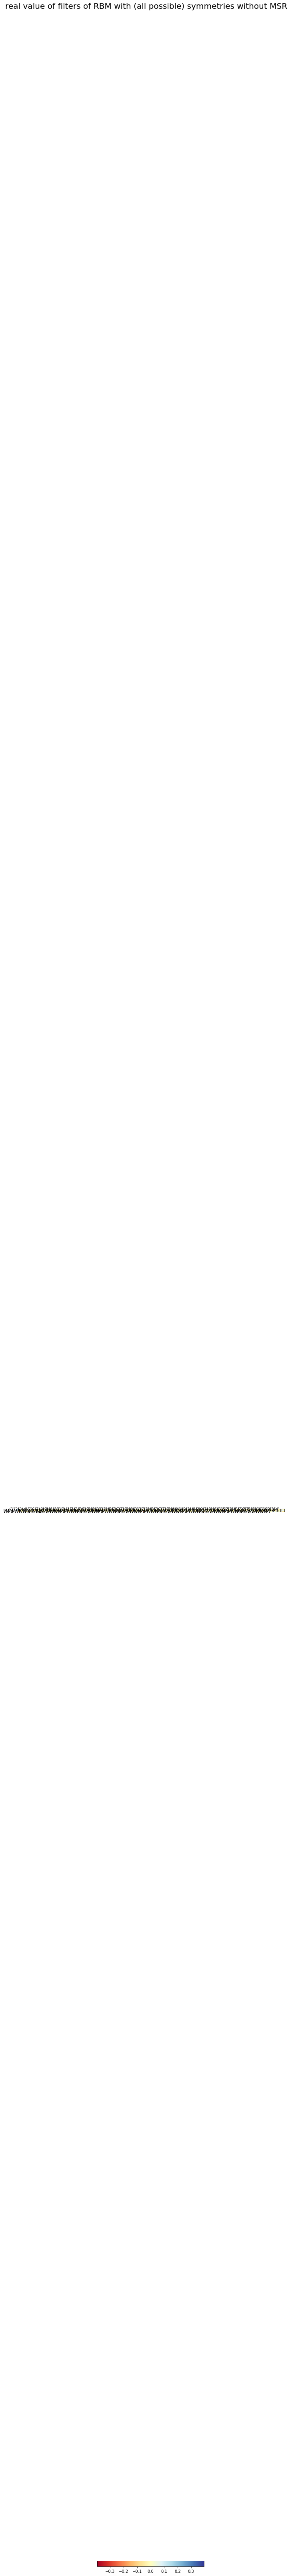

In [272]:
L_NUM = 4
fig, axs = plt.subplots(1, no_of_filters, figsize=(12,2*no_of_filters))
#fig.tight_layout(pad=.0)
fig.subplots_adjust(top=1.9,bottom=0,wspace=.4)
fig.suptitle("real value of filters of RBM with (all possible) symmetries without MSR", fontsize=20)
for a in range(no_of_filters):
    im = axs[a].imshow(np.real(Filters[a]).reshape(L_NUM,L_NUM), cmap="RdYlBu", vmin=-extreme,vmax=extreme)#,interpolation="spline16")
    axs[a].set_ylabel(r"$W^{("+str(a+1)+r")}$", rotation=None,fontsize="x-large",horizontalalignment="right",verticalalignment="center")
    axs[a].tick_params(left=False, right=False, labelleft=False, labelbottom=False, bottom=False)

# Now adding the colorbar
cbar = fig.colorbar(im, ax=axs.ravel().tolist(), orientation="horizontal", shrink=.4)

plt.show()